## Download testing data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glacierpoly as gpoly
import glob
import matplotlib.pyplot as plt

In [3]:
import cv2
import cartopy
import copy
import glob
import geopandas as gpd
import img2pdf
import numpy as np
import os
import pandas as pd
from pathlib import Path
import rasterio
from rasterio import mask
from rasterio.plot import show
from rasterstats import zonal_stats
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import polygonize
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table
import subprocess
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


In [4]:
reference_dem_file = '/mnt/Backups/knuth/paper/south_cascade/final_products/scg_test_data/reference_dem.tif'
reference_glacier_polygon_file = '/mnt/Backups/knuth/paper/south_cascade/final_products/scg_test_data/rgi_glacier_oultine.geojson'
difference_maps_files = sorted(glob.glob('/mnt/Backups/knuth/paper/south_cascade/final_products/scg_test_data/dod*.tif'))
ortho_files = sorted(glob.glob('/mnt/Backups/knuth/paper/south_cascade/final_products/scg_test_data/ortho*.tif'))

In [7]:
gpoly.core.run_detection(reference_dem_file,
                  difference_maps_files,
                  reference_glacier_polygon_file,
                     ortho_files = ortho_files,    
                  output_directory = 'outputs')

processing dod_1967-09-21
detected polygon does not intersect reference polygon
reattempting detection without eroding islands
SUCCESS

processing dod_1970-09-29
SUCCESS

processing dod_1974-08-10
SUCCESS

processing dod_1977-10-03
SUCCESS

processing dod_1979-08-20
SUCCESS

processing dod_1979-10-06
detected polygon does not intersect reference polygon
reattempting detection without eroding islands
SUCCESS

processing dod_1984-08-14
SUCCESS

processing dod_1986-09-05
SUCCESS

processing dod_1987-08-21
SUCCESS

processing dod_1990-09-05
SUCCESS

processing dod_1991-09-09
SUCCESS

processing dod_1992-07-28
SUCCESS

processing dod_1992-09-15
SUCCESS

processing dod_1992-09-18
SUCCESS

processing dod_1992-10-06
SUCCESS

processing dod_1994-09-06
SUCCESS

processing dod_1996-09-10
SUCCESS

processing dod_1997-09-23
SUCCESS



In [8]:
gpoly.core.run_detection(reference_dem_file,
                  [difference_maps_files[0],],
                  reference_glacier_polygon_file,
                     ortho_files = [ortho_files[0],],
                         dilation_iterations=2,
                  output_directory = 'outputs')

processing dod_1967-09-21
detected polygon does not intersect reference polygon
reattempting detection without eroding islands
SUCCESS



In [8]:
detected_polygon_gdf = 'outputs/glacier_outline_detected_1967-09-21.geojson'

In [9]:
gdf = gpd.read_file(detected_polygon_gdf)

<AxesSubplot:>

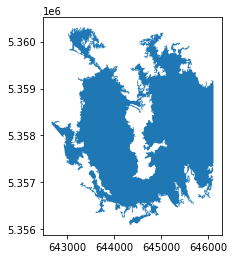

In [11]:
gdf.plot()

In [15]:
# gpoly.core.remove_inlet_islands(detected_polygon_gdf,buffer_distance=10)

In [17]:
buffer_distance = 10

In [ ]:
tmp = gpd.GeoDataFrame(geometry=gdf.buffer(buffer_distance)).dissolve().explode().reset_index().iloc[: , 2:]


In [ ]:
tmp

In [ ]:
difference_map_file = difference_maps_files[0]
merged_polygon_file = 'outputs/glacier_outline_detected_1967-09-21.geojson'
output_directory = './'

In [8]:
! ls outputs/*6.geojson

outputs/glacier_outline_detected_1979-10-06.geojson
outputs/glacier_outline_detected_1992-10-06.geojson
outputs/glacier_outline_detected_1994-09-06.geojson
outputs/glacier_outline_full_1979-10-06.geojson
outputs/glacier_outline_full_1992-10-06.geojson
outputs/glacier_outline_full_1994-09-06.geojson


In [85]:
def plot_tif_with_polygons(
    difference_map_file,
    reference_glacier_polygon_file,
    merged_polygon_file,
    output_directory,
    suffix=None,
    cmap_name=None,
    cbar_label = None,
    bad_value_color='none',
    alpha = 1,
    vmin=None,
    vmax=None,
    vmin_percentile = 30, # values for orthos 0-255
    vmax_percentile = 99, # values for orthos 0-255
    cbar_fraction=0.035,
):

    cmap = copy.copy(plt.cm.get_cmap(cmap_name))
    cmap.set_bad(color=bad_value_color)

    Path(output_directory).mkdir(parents=True, exist_ok=True)
    file_name = str(Path(difference_map_file).stem)
    qc_plot_file_name = file_name.split("_")[-1] + suffix

    source = rasterio.open(difference_map_file)

    if vmin == None and vmax == None:
        array = source.read(1)
        array = array.astype(float)
        array = gpoly.core.replace_and_fill_nodata_value(array, source.nodata, np.nan)
        vmin, vmax = np.nanpercentile(array, [vmin_percentile, vmax_percentile])

    fig, ax = plt.subplots(figsize=(10, 10))

    sm = ax.imshow(source.read(1), cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)

    crs = cartopy.crs.epsg(source.crs.to_epsg())

    ax = plt.axes(projection=crs)
    #     ax.set_facecolor('black')

    show(
        source, cmap=cmap, ax=ax, interpolation="none", vmin=vmin, vmax=vmax, alpha=alpha
    )

    cb = fig.colorbar(
        sm, ax=ax, fraction=cbar_fraction, pad=0.001, extend="both", aspect=50
    )
    cb.set_label(label=cbar_label, size=15)
    cb.ax.tick_params(labelsize=12)

    reference_glacier_polygon = gpd.read_file(reference_glacier_polygon_file)
    merged_polygon = gpd.read_file(merged_polygon_file)

    reference_glacier_polygon.plot(ax=ax, facecolor="none", edgecolor="b",linewidth=3)
    merged_polygon.plot(ax=ax, facecolor="none", edgecolor="g",linewidth=3)

    if reference_glacier_polygon.geometry.area[0] > merged_polygon.geometry.area[0]:
        tmp_poly = reference_glacier_polygon
    else:
        tmp_poly = merged_polygon
    bounds = tmp_poly.geometry.total_bounds
    xlim = [bounds[0] - 10, bounds[2] + 10]
    ylim = [bounds[1] - 10, bounds[3] + 10]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    rgi_area = str(np.around((reference_glacier_polygon.area[0] / 1e6), 2))
    detected_area = str(np.around((merged_polygon.area[0] / 1e6), 2))

    labels = [
        "RGI area " + rgi_area + " km2",
        "Detected area " + detected_area + " km2",
    ]
    patches = [
        Line2D([0], [0], color="b", label=labels[0]),
        Line2D([0], [0], color="g", label=labels[1]),
    ]
    ax.legend(handles=patches)
    ax.set_title(file_name.split("_")[-1])
    #         ax.fill_between([0,1],[1,1],hatch="X")

    fig.savefig(
        os.path.join(output_directory, qc_plot_file_name + ".jpg"),
        bbox_inches="tight",
        pad_inches=0,
    )
    plt.close()

In [86]:
merged_polygon_file = 'outputs/glacier_outline_full_1994-09-06.geojson'
difference_map_file = difference_maps_files[-3]
ortho_file = ortho_files[-3]

In [87]:
plot_tif_with_polygons(
    ortho_file,
    reference_glacier_polygon_file,
    merged_polygon_file,
    './',
    suffix="_01_ortho",
    cmap_name="Greys",
    alpha = 1,
    bad_value_color='yellow',
)

In [91]:
plot_tif_with_polygons(
    difference_map_file,
    reference_glacier_polygon_file,
    merged_polygon_file,
    './',
    suffix="_01_dod",
    cmap_name="RdBu",
    vmin=-10,
    vmax=10,
    alpha = 1,
    bad_value_color='black',
)

In [ ]:
difference_map_file = difference_maps_files[-3]
dilation_iterations=4
detected_polygon_file = 'outputs/glacier_outline_detected_1994-09-06.geojson'

In [ ]:
# file_name = str(Path(difference_map_file).stem)
# print("processing", file_name)

# transform, res, crs = gpoly.core.get_raster_metadata(difference_map_file)
# array = gpoly.core.clip_raster_by_buffer(
#     difference_map_file, reference_glacier_polygon_file, buffer_distance=2000
# )

# arrays = gpoly.core.detect_glacier(
#     array, erode_islands=True, dilation_iterations=dilation_iterations
# )

# detected_array = arrays[-1]
# detected_polygon_gdf = gpoly.core.convert_glacier_array_to_gdf(
#     detected_array, transform, res, crs
# )

# detected_polygon_gdf = gpoly.core.find_largest_intersecting_detected_polygon(
#     reference_glacier_polygon_file, detected_polygon_gdf
# )
# merged = gpoly.core.merge_with_undetected_high_elevation_areas(
#     reference_dem_file,
#     reference_glacier_polygon_file,
#     detected_polygon_file,
# )

In [ ]:
# arrays

In [ ]:
# create qc plots
file_name = str(Path(difference_map_file).stem)

labels = [
    "unit8 array",
    "canny edges",
    "dilated edges",
    "area closing",
    "largest area",
    "final polygon",
]
fig = plt.figure(figsize=(10, 8))
qc_plot_file_name = file_name.split("_")[-1] + "_00_gallery"
fig.suptitle(file_name.split("_")[-1])
rows = 2
columns = 3
for i in range(rows * columns):
    try:
        arr = arrays[i]
        ax = plt.subplot(rows, columns, i + 1)
        if labels[i] == "canny edges" or labels[i] == "dilated edges":
            ax.imshow(arr,vmin=0,vmax=1)
        else:
            ax.imshow(arr)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(labels[i])
    except:
        try:
            ax = plt.subplot(rows, columns, i + 1)
            try:
                merged.plot(ax=ax)
            except:
                pass
            detected_polygon_gdf.plot(ax=ax, color="r")
            ax.set_xticks(())
            ax.set_yticks(())
            ax.set_title(labels[i])
            labels = ["fill from rgi", "detected"]
            patches = [
                Patch(facecolor="C0", label=labels[0]),
                Patch(facecolor="r", label=labels[1]),
            ]
            ax.legend(handles=patches)
        except:
            pass
plt.tight_layout()

In [ ]:
gpoly.plotting.create_detection_qc_gallery(
    arrays,
    detected_polygon_gdf,
    './',
    difference_map_file,
    merged=merged,
)

In [ ]:
import hvplot
import hvplot.pandas  # noqa
import hvplot.xarray  # noqa
# import geoviews as gv
import xarray as xr
import rioxarray
import holoviews as hv

from holoviews import opts
from holoviews.streams import PointDraw, PolyEdit, BoxEdit, PolyDraw, FreehandDraw
from holoviews.operation.datashader import regrid

In [ ]:
outlines = sorted(glob.glob('outputs/*geojson'))

In [ ]:
gdf = gpd.read_file(outlines[1])
gdf = gdf.explode().reset_index().iloc[: , 2:]
gdf = gdf[gdf.area == gdf.area.max()]

mask_poly = gdf.geometry.iloc[0].exterior.coords.xy
mask_poly = hv.Polygons(mask_poly).opts(show_legend=True)
mask_poly = mask_poly.relabel('detected')

In [ ]:
gdf = gpd.read_file(reference_glacier_polygon_file)
gdf = gdf.explode().reset_index().iloc[: , 2:]
gdf = gdf[gdf.area == gdf.area.max()]

mask_poly2 = gdf.geometry.iloc[0].exterior.coords.xy
mask_poly2 = hv.Polygons(mask_poly2).opts(show_legend=True)
mask_poly2 = mask_poly2.relabel('rgi')

In [ ]:
vertex_stream = PolyEdit(source=mask_poly)

In [ ]:
da = rioxarray.open_rasterio(difference_maps_files[1],masked=True)
da.name='dod'
img = hv.Dataset(da).to(hv.Image, ["x", "y"]).opts(cmap="RdBu", 
                                                   clim=(-10,10), 
                                                   aspect=1, 
                                                   frame_height=500)

In [ ]:
# regrid(img) * mask_poly * mask_poly2

In [ ]:
# arrays = [np.column_stack([xs, ys]) for xs, ys in zip(vertex_stream.data['xs'], vertex_stream.data['ys'])]

In [ ]:
# vertex_stream.element.data

In [ ]:
# len(vertex_stream.element.data[1]['x'])

In [ ]:
# Polygon(arrays[0])

In [ ]:
ortho_files[0]

In [ ]:
da = rioxarray.open_rasterio(ortho_files[0],masked=True)
da = da[da.band==2]
da.name='ortho'

ds = xr.Dataset()
for i, v in enumerate(da.band):
    da_tmp = da.sel(band=v)
    da_tmp.name = "band" + str(i + 1)

    ds[da_tmp.name] = da_tmp
del ds.coords["band"]

In [ ]:
img2 = hv.Dataset(ds['band1']).to(hv.Image, ["x", "y"]).opts(cmap="RdBu", 
                                                             clim=(-10,10), 
                                                             aspect=1, 
                                                             frame_height=500,
                                                             rasterize=True)

In [ ]:
regrid(img) * mask_poly * regrid(img2)